## Description

Given list of bank locations, how much money each one holds and the time it would take to rob each one, one needs to apply algorithm knowledge to collect as much money as possible.

The list of banks is in `data/bank_data.csv`. This is what the data looks like.

```csv
id, x_coordinate (km), y_coordinate (km), money, time (hr)
0, 11.4, 3.3, 5000, 0.6
1, 6.9, 7.1, 15000, 0.3
2, 1.4, 13.2, 900, 1.1
```

One has **24 hours** to make as much money as possible and then escape.

## Rules

- The run can start anywhere on the map but it has to end at the **helicopter escape zone**: coordinates (0,0)
    - If one try to rob too many banks and can't get to the helicopter in 24 hours, one gets caught and go to jail.

- The solution is a list of numbers (eg. `[580, 433, 24, 998]`) where the numbers are the IDs of each bank. The ID of each bank is the id column.

- The travel speed between banks is 30 km/h.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.cluster import KMeans

In [2]:
df=pd.read_csv("./data/bank_data.csv")

In [3]:
num_bank = 265 # for optimization, this number needs to be very close to the total number of banks robbed
num_cluster = 20 # number of clusters used for clustering analysis

In [4]:
bank = df.copy()

# create the value column representing the ratio of money/rob_time for each bank
bank['value'] = bank['money']/bank['time (hr)']/(10**8)

# create the time_to_escape column representing the time it takes to go to the escape zone from each bank
bank['time_to_escape'] = np.sqrt(bank['x_coordinate']**2 + bank['y_coordinate']**2)/30

# sort the dataframe by the value column in a descending order
bank = bank.sort_values(by='value',ascending=False)
bank = bank.reset_index(drop=True)

# removing all the low value banks
bank = bank[:num_bank]

# generate clusters of banks
X = bank[['x_coordinate', 'y_coordinate']] # choose x and y coordinates as features
kmeans = KMeans(n_clusters=num_cluster)
kmeans.fit(X)
bank['cluster'] = pd.Series(kmeans.labels_) # assign clusters labels to each bank
centroids = kmeans.cluster_centers_
distances_to_origin = np.linalg.norm(centroids, axis=1)
# create the centroid_to_origin column representing distance between the centroid of each cluster and the escape zone
bank['centroid_to_origin']=bank['cluster'].apply(lambda x: distances_to_origin[x])

# sort the dataframe by the centroid_to_origin column then by the time_to_escape column
bank = bank.sort_values(by=['centroid_to_origin', 'time_to_escape'], ascending=[False, False])
bank.head()

/Users/tsingzhang/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,id,x_coordinate,y_coordinate,money,time (hr),value,time_to_escape,cluster,centroid_to_origin
74,7665,4.905339,-4.473730,96800,0.052215,0.018539,0.221301,16,5.906341
127,5166,4.421419,-4.920043,64300,0.062964,0.010212,0.220494,16,5.906341
197,9640,3.779429,-4.941082,56500,0.094185,0.005999,0.207360,16,5.906341
121,8846,4.231074,-4.530839,40100,0.037193,0.010782,0.206641,16,5.906341
115,8231,3.768828,-4.592543,63200,0.054594,0.011576,0.198033,16,5.906341


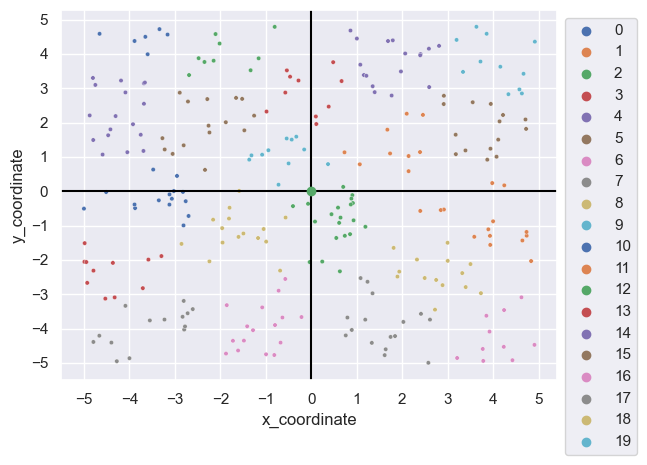

In [5]:
# visualize the clusters on the xy plane
sns.scatterplot(x='x_coordinate', y='y_coordinate', data=bank, hue='cluster', palette='deep', s=10)
plt.xticks(np.arange(-5,6))
plt.yticks(np.arange(-5,6))
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.axvline(x = 0, color = 'black', linestyle = '-')
plt.plot(0,0,'go') 
plt.show()

In [6]:
# add a few more new columns to the dataframe
bank['travel_time'] = np.sqrt((bank['x_coordinate'].diff(periods=-1))**2 + (bank['y_coordinate'].diff(periods=-1))**2)/30
bank['total_time'] = bank['time (hr)'] + bank['travel_time']
bank['total_time_cumsum'] = bank['total_time'].cumsum()
bank['money_cumsum'] = bank['money'].cumsum()
bank = bank.reset_index(drop=True)

bank.tail(10)

,id,x_coordinate,y_coordinate,money,time (hr),value,time_to_escape,cluster,centroid_to_origin,travel_time,total_time,total_time_cumsum,money_cumsum
255,2639,0.913300,-0.344901,47200,0.082919,0.005692,0.032542,2,1.047442,0.002018,0.084937,23.538888,13106300
256,7494,0.868299,-0.385415,68600,0.110136,0.006229,0.031666,2,1.047442,0.009134,0.119270,23.658158,13174900
257,5971,0.901328,-0.113385,57100,0.074221,0.007693,0.030281,2,1.047442,0.003443,0.077664,23.735822,13232000
258,4359,0.879627,-0.214365,20300,0.044486,0.004563,0.030179,2,1.047442,0.034737,0.079223,23.815045,13252300
259,1966,0.080528,-0.883274,45600,0.073223,0.006228,0.029565,2,1.047442,0.014041,0.087264,23.902308,13297900
260,6254,0.443017,-0.668725,55100,0.051632,0.010672,0.026739,2,1.047442,0.007965,0.059597,23.961905,13353000
261,1455,0.586321,-0.477507,78800,0.078889,0.009989,0.025205,2,1.047442,0.020495,0.099384,24.061290,13431800
262,3340,0.700413,0.126678,92900,0.197687,0.004699,0.023726,2,1.047442,0.041280,0.238966,24.300256,13524700
263,5135,-0.404042,-0.433493,73900,0.009476,0.077990,0.019753,2,1.047442,0.011296,0.020772,24.321028,13598600
264,3971,-0.072039,-0.365538,56200,0.122544,0.004586,0.012419,2,1.047442,NaN,NaN,NaN,13654800


In [7]:
# find the bank IDs and print out final results
for i in range(num_bank):
    selected = bank[:i+1]
    last = selected.iloc[-1] # last row which is the last bank robbed
    if (last['total_time_cumsum'] - last['travel_time'] + last['time_to_escape']) > 24:
        print(f"Bank IDs:{bank['id'][:i].tolist()}\n")
        print(f"Number of banks robbed: {i}\n")
        print(f"Total amount of Money robbed: {bank['money_cumsum'].iloc[i-1]}")
        break

Bank IDs:[7665, 5166, 9640, 8846, 8231, 2626, 232, 2442, 6339, 9448, 4175, 9908, 3136, 1193, 8849, 1599, 6623, 4762, 299, 4983, 6468, 5295, 8286, 1914, 1058, 4742, 8703, 6561, 7625, 317, 2346, 2741, 8909, 8469, 9049, 3297, 9401, 8966, 7769, 2656, 8206, 3526, 1397, 9241, 2928, 6156, 8605, 9378, 5296, 5126, 2769, 4725, 7764, 7701, 7649, 2729, 8890, 664, 6740, 7258, 2194, 9928, 8169, 6281, 7074, 517, 4214, 9290, 9460, 7689, 4605, 7877, 4696, 1961, 4789, 3026, 1757, 8355, 2037, 6712, 8579, 1676, 8288, 3193, 8022, 9130, 9455, 7343, 3803, 487, 7560, 5933, 2185, 6022, 3665, 507, 5572, 5836, 5298, 4807, 9228, 524, 4794, 6535, 6764, 2190, 7772, 4364, 5440, 8784, 2521, 4218, 8829, 4362, 2643, 2331, 4757, 5474, 4499, 3239, 4234, 3186, 6216, 3484, 1053, 1424, 4465, 5155, 2590, 5200, 4627, 9736, 4492, 1926, 1723, 2859, 5381, 9469, 4723, 9275, 3637, 670, 5327, 2162, 8949, 488, 279, 6934, 3466, 2226, 444, 6169, 865, 5873, 9880, 5563, 3585, 9583, 3089, 7583, 1081, 4494, 1684, 3005, 790, 3007, 5944, 70